<a href="https://colab.research.google.com/github/samveddubey/Bioinformatics-Projects/blob/main/Copy_of_Confindence_Interval_Probit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install primer3-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 20.8 MB/s eta 0:00:00


In [ ]:
import pandas

Optimization terminated successfully.
         Current function value: 0.256798
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.295378
         Iterations 8
[(0.15769169465194716, 0.3063175018876033), (0.17608396165308632, 0.3262076056806951), (0.1956982080100823, 0.34671288469898404), (0.21648792859000437, 0.3678004405818262), (0.23838868384733314, 0.38943385675599596), (0.2613183315316312, 0.41157322084077164), (0.28517780943976645, 0.4341750658514039), (0.309852510907124, 0.4571921955043481), (0.3352142762405774, 0.4805733615283691), (0.36112399595520084, 0.5042627718892867), (0.38743478261736275, 0.5281994318531512), (0.41399561565602305, 0.5523163572633915), (0.44065529950070315, 0.5765397502026605), (0.467266507738806, 0.6007882841082739), (0.49368962999468624, 0.62497269361992), (0.5197961145776732, 0.6489958837016834), (0.5454710276272521, 0.6727537441258005), (0.5706146356496097, 0.6961367721289196), (0.5951429503587924, 0.7190324

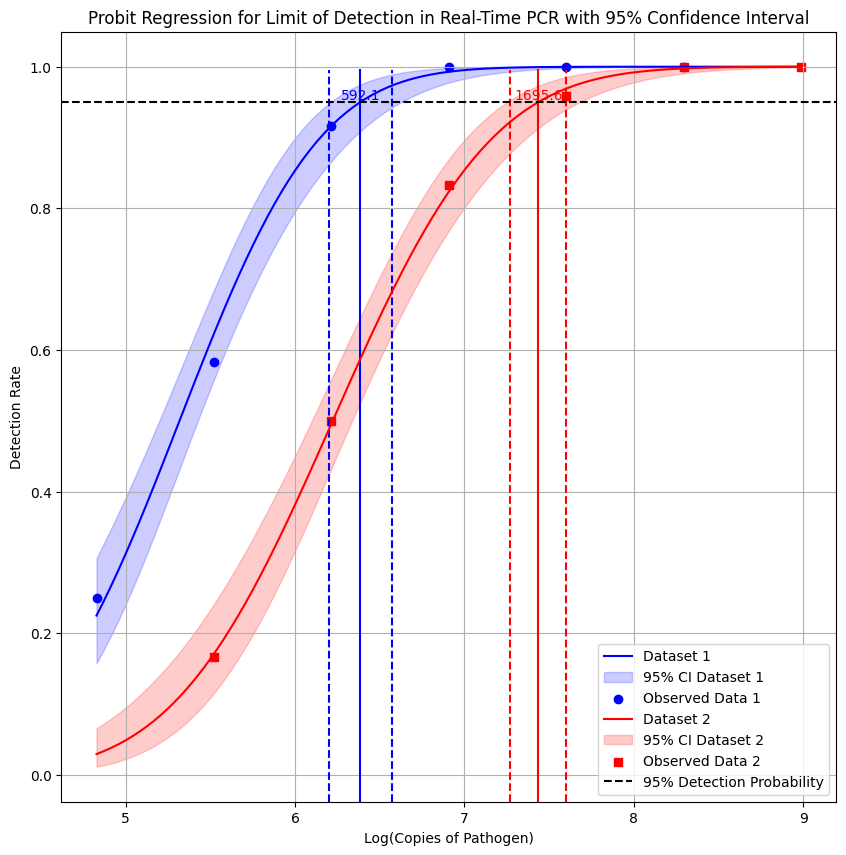

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example data for two datasets
data1 = pd.DataFrame({
    'copies': [4000, 2000, 1000, 500, 250, 125],
    'total': [24, 24, 24, 24, 24, 24],
    'positive': [24, 24, 24, 22, 14, 6]
})

data2 = pd.DataFrame({
    'copies': [8000, 4000, 2000, 1000, 500, 250],
    'total': [24, 24, 24, 24, 24, 24],
    'positive': [24, 24, 23, 20, 12, 4]
})

def prepare_data(data):
    data['log_copies'] = np.log(data['copies'] )  # Add 1 to avoid log(0)
    data['proportion'] = data['positive'] / data['total']

    binary_outcomes = []
    log_copies_repeated = []
    for idx, row in data.iterrows():
        binary_outcomes.extend([1] * int(row['positive']) + [0] * (int(row['total']) - int(row['positive'])))
        log_copies_repeated.extend([row['log_copies']] * int(row['total']))

    binary_data = pd.DataFrame({
        'log_copies': log_copies_repeated,
        'outcome': binary_outcomes
    })
    return binary_data

def fit_probit_model(binary_data):
    model = sm.Probit(binary_data['outcome'], sm.add_constant(binary_data['log_copies']))
    result = model.fit()
    return result

def calculate_confidence_intervals(result, log_copies_range):
    predicted_probs_ci = []
    params = result.params
    cov_params = result.cov_params()
    #z_value = 1.96  # For 95% confidence interval

    for log_copy in log_copies_range:
        X = np.array([1, log_copy])
        mean_prob = result.predict([X])[0]   #predict response variable
        se = np.sqrt(X @ cov_params @ X.T)
        lower_bound = norm.cdf(norm.ppf(mean_prob) -  se)
        upper_bound = norm.cdf(norm.ppf(mean_prob) +  se)
        predicted_probs_ci.append((lower_bound, upper_bound))
        #print(se)
    print(predicted_probs_ci)
    predicted_probs_ci = np.array(predicted_probs_ci)
    return predicted_probs_ci

def calculate_lod(result):
    lod_prob = 0.95
    params = result.params
    cov_params = result.cov_params()
    lod_log_copies = (norm.ppf(lod_prob) - params[0]) / params[1]

    # Calculate the 95% CI for the LoD
    lod_se = np.sqrt(cov_params.loc['log_copies', 'log_copies'] / params[1]**2)
    lod_lower = lod_log_copies - lod_se
    lod_upper = lod_log_copies + lod_se
    #print(lod_se)
    return lod_log_copies, lod_lower, lod_upper

def plot_results(data1, data2, result1, result2):
    log_copies_range = np.linspace(min(data1['log_copies'].min(), data2['log_copies'].min()),
                                   max(data1['log_copies'].max(), data2['log_copies'].max()), 100)

    predicted_probs1 = result1.predict(sm.add_constant(log_copies_range))
    predicted_probs2 = result2.predict(sm.add_constant(log_copies_range))

    predicted_probs_ci1 = calculate_confidence_intervals(result1, log_copies_range)
    predicted_probs_ci2 = calculate_confidence_intervals(result2, log_copies_range)

    lod_log_copies1, lod_lower1, lod_upper1 = calculate_lod(result1)
    lod_log_copies2, lod_lower2, lod_upper2 = calculate_lod(result2)
    print(lod_lower1)
    print(lod_upper1)

    print(lod_lower2)
    print(lod_upper2)
    plt.figure(figsize=(10, 10))
    #print(lod_se)
    # Plot the first dataset
    plt.plot(log_copies_range, predicted_probs1, label='Dataset 1', color='blue')
    plt.fill_between(log_copies_range, predicted_probs_ci1[:, 0], predicted_probs_ci1[:, 1], color='blue', alpha=0.2, label='95% CI Dataset 1')
    plt.scatter(data1['log_copies'], data1['proportion'], color='blue', marker='o', label='Observed Data 1')
    plt.axvline(lod_log_copies1, color='blue', linestyle='-',ymin=0, ymax=0.95)
##
    plt.axvline(lod_lower1, color='blue', linestyle='--',ymin=0, ymax=0.95)
    plt.axvline(lod_upper1, color='blue', linestyle='--',ymin=0, ymax=0.95)
##
    plt.text(lod_log_copies1, 0.95, f'{np.exp(lod_log_copies1)-1:.1f}', color='blue', ha='center', va='bottom')

    # Plot the second dataset
    plt.plot(log_copies_range, predicted_probs2, label='Dataset 2', color='red')
    plt.fill_between(log_copies_range, predicted_probs_ci2[:, 0], predicted_probs_ci2[:, 1], color='red', alpha=0.2, label='95% CI Dataset 2')
    plt.scatter(data2['log_copies'], data2['proportion'], color='red', marker='s', label='Observed Data 2')
    plt.axvline(lod_log_copies2, color='red', linestyle='-',ymin=0, ymax=0.95)

    plt.axvline(lod_lower2, color='red', linestyle='--', ymin=0, ymax=0.95)
    plt.axvline(lod_upper2, color='red', linestyle='--', ymin=0, ymax=0.95)

    plt.text(lod_log_copies2, 0.95, f'{np.exp(lod_log_copies2)-1:.1f}', color='red', ha='center', va='bottom')

    # Plot LoD 95% detection probability line
    plt.axhline(0.95, color='black', linestyle='--', label='95% Detection Probability')

    # Labels and title
    plt.xlabel('Log(Copies of Pathogen)')
    plt.ylabel('Detection Rate')
    plt.title('Probit Regression for Limit of Detection in Real-Time PCR with 95% Confidence Interval')
    plt.legend()
    plt.grid(True)
    plt.show()

binary_data1 = prepare_data(data1)
binary_data2 = prepare_data(data2)

result1 = fit_probit_model(binary_data1)
result2 = fit_probit_model(binary_data2)

plot_results(data1, data2, result1, result2)


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import chi2

# Example data for two datasets
data1 = pd.DataFrame({
    'dose': [4000, 2000, 1000, 500, 250, 125],
    'total': [24, 24, 24, 24, 24, 24],
    'positive': [24, 24, 24, 22, 14, 6]
})

data2 = pd.DataFrame({
    'dose': [8000, 4000, 2000, 1000, 500, 250],
    'total': [24, 24, 24, 24, 24, 24],
    'positive': [24, 24, 23, 20, 12, 4]
})

def prepare_data(data):
    data['log_dose'] = np.log(data['dose'] + 0.9999999)  # Add small value to avoid log(0)
    data['proportion'] = data['positive'] / data['total']

    binary_outcomes = []
    log_dose_repeated = []
    for idx, row in data.iterrows():
        binary_outcomes.extend([1] * int(row['positive']) + [0] * (int(row['total']) - int(row['positive'])))
        log_dose_repeated.extend([row['log_dose']] * int(row['total']))

    binary_data = pd.DataFrame({
        'log_dose': log_dose_repeated,
        'outcome': binary_outcomes
    })
    return binary_data

# Prepare data
binary_data1 = prepare_data(data1)
binary_data2 = prepare_data(data2)
print(binary_data1)
# Function to fit model and compute log-likelihoods and coefficients
def fit_probit_model(binary_data):
    # Full model (intercept and log_dose)
    X_full = sm.add_constant(binary_data['log_dose'])
    full_model = sm.Probit(binary_data['outcome'], X_full)
    full_result = full_model.fit(disp=False)

    # Extracting coefficients and standard errors
    coefficients = full_result.params
    standard_errors = full_result.bse

    # Calculating Wald statistics
    wald_statistics = (coefficients / standard_errors)**2

    return {
        'coefficients': coefficients,
        'standard_errors': standard_errors,
        'wald_statistics': wald_statistics,
        'p_values': full_result.pvalues,
        'full_model': full_result
    }

# Fit models for both datasets
results1 = fit_probit_model(binary_data1)
results2 = fit_probit_model(binary_data2)

# Printing results for Data 1
print("Results for Data 1:")
print(f"Coefficients: \n{results1['coefficients']}")
print(f"Standard Errors: \n{results1['standard_errors']}")
print(f"Wald Statistics: \n{results1['wald_statistics']}")
print(f"P-values: \n{results1['p_values']}")

# Printing results for Data 2
print("\nResults for Data 2:")
print(f"Coefficients: \n{results2['coefficients']}")
print(f"Standard Errors: \n{results2['standard_errors']}")
print(f"Wald Statistics: \n{results2['wald_statistics']}")
print(f"P-values: \n{results2['p_values']}")





# Given probit values and their corresponding probabilities
probit_table = pd.DataFrame({
    'probit': [2.326, 1.645, 1.282, 0.842, 0.000, -0.842, -1.282, -1.645, -2.326],
    'p': [0.99, 0.95, 0.90, 0.80, 0.50, 0.20, 0.10, 0.05, 0.01]
})

# Given coefficients a and b
#a1,b1 = results1['coefficients']
# Given coefficients a and b
a = -2.61
b = 6.36

# Function to calculate dose based on predicted probability
def calculate_dose(predicted_prob, a, b):
    # Find the corresponding probit value for the given probability
    probit_value = np.interp(predicted_prob, probit_table['p'], probit_table['probit'])

    # Calculate dose using the given formula
    dose = (probit_value - a) / b
    return dose

# Example usage
predicted_probs = [0.99, 0.95, 0.90, 0.80, 0.50, 0.20, 0.10, 0.05, 0.01]

p=0.95
dose = calculate_dose(p, a, b)
print(f"Predicted Probability: {p}, Calculated Dose: {dose}")

     log_dose  outcome
0    8.294300        1
1    8.294300        1
2    8.294300        1
3    8.294300        1
4    8.294300        1
..        ...      ...
139  4.836282        0
140  4.836282        0
141  4.836282        0
142  4.836282        0
143  4.836282        0

[144 rows x 2 columns]
Results for Data 1:
Coefficients: 
const      -8.240289
log_dose    1.547840
dtype: float64
Standard Errors: 
const       1.591635
log_dose    0.289073
dtype: float64
Wald Statistics: 
const       26.803893
log_dose    28.670635
dtype: float64
P-values: 
const       2.251833e-07
log_dose    8.579490e-08
dtype: float64

Results for Data 2:
Coefficients: 
const      -8.450831
log_dose    1.357554
dtype: float64
Standard Errors: 
const       1.447858
log_dose    0.225561
dtype: float64
Wald Statistics: 
const       34.068002
log_dose    36.223149
dtype: float64
P-values: 
const       5.321927e-09
log_dose    1.759678e-09
dtype: float64
Predicted Probability: 0.95, Calculated Dose: 0.04465408805